<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/owr/owr-ensebles-mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Avoid K80
!nvidia-smi

Tue Jul 13 10:17:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from copy import copy
from copy import deepcopy

#### Cloning the Git repository

In [3]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 3585, done.
remote: Counting objects: 100% (1001/1001), done.
remote: Compressing objects: 100% (437/437), done.
remote: Total 3585 (delta 576), reused 935 (delta 547), pack-reused 2584
Receiving objects: 100% (3585/3585), 182.55 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (1961/1961), done.
Checking out files: 100% (395/395), done.
/content/ProjectMLDL


In [4]:
from data.cifar100 import CIFAR100
from model.resnet32_modified import resnet32
import data.utils
from model.owrEnsamble import owrEnsemble

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

## Incremental Classifier and Representation Learning

### Defining hyperparameters according to iCarl paper

In [6]:
# Settings
DEVICE = 'cuda'
NUM_CLASSES = 100         # Total number of classes
VAL_SIZE = 0.2            # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128          # Batch size
LR = 0.1                    # Initial learning rate
                       
MOMENTUM = 0.9            # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5       # Weight decay from iCaRL

RANDOM_SEED = [20]  # Random seeds defining the runs of every method
                          # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70           # Total number of training epochs
MILESTONES = [43, 63]     # Step down policy from iCaRL (MultiStepLR)
                          # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2               # Gamma factor from iCaRL (1/5)

HERDING = False           # True to perform prioritized selection, False to perform random selection
CLASSIFY = True           # True to use mean-of-exemplar classifier, False to use network's output directly for classification

REJECTION_THRESHOLD = [0.25,0.35,0.50,0.60,0.75,0.85,0.95]
TESTING_MODE = 'harmonic' #open, closed, harmonic
N_ESTIMATORS = 5
CONFIDENCE = '0.900' #'0.6827': 1, '0.900':1.47, '0.950':1.94, '0.975':2.45, '0.990':3.36
STRATEGY = 'mean' # mean, variance, hybrid
    

In [7]:
def do_group_classes(run):

  train_subset = [[] for i in range(10)]
  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]

  for i in range(10):
    train_data = CIFAR100("dataset", 
                          train=True, 
                          transform=train_transform, 
                          download=(run+i==0),
                          random_state=RANDOM_SEED[run])
    test_data = CIFAR100("dataset", 
                         train=False, 
                         transform=test_transform, 
                         download=False,
                         random_state=RANDOM_SEED[run])
    
    train_data.set_index_map(train_data.splits[i])
    test_data.set_index_map([test_data.splits[j] for j in range(0, i+1)])
    
    train_indices, val_indices = train_data.train_val_split(VAL_SIZE, RANDOM_SEED[run])
    
    train_subset[i] = copy(Subset(train_data, train_indices))
    val_subset = Subset(train_data, val_indices)

    tmp_dl = DataLoader(val_subset,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    val_dataloader[i] = copy(tmp_dl)

    tmp_dl = DataLoader(test_data,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    test_dataloader[i] = copy(tmp_dl)

  return train_dataloader, val_dataloader, test_dataloader, train_subset

### Going on with the model
This is the main iCaRL step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.

In [8]:
logs = [[] for i in range(len(RANDOM_SEED))]
best_net_tot_classes = [None for i in range(len(RANDOM_SEED))]

for run in range(len(RANDOM_SEED)):
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")

  # get data_subsets separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl, train_set = do_group_classes(run)

  #create the resnet
  net = resnet32()
  
  trainer = owrEnsemble(DEVICE,
                  net,
                  LR,
                  MOMENTUM,
                  WEIGHT_DECAY,
                  MILESTONES,
                  GAMMA,
                  train_dl,
                  val_dl,
                  test_dl,
                  BATCH_SIZE,
                  train_set,
                  train_transform,
                  test_transform,
                  TESTING_MODE,
                  REJECTION_THRESHOLD,
                  N_ESTIMATORS,
                  CONFIDENCE,
                  STRATEGY) 

  #train and evaluate the model
  logs[run] = trainer.train_model(NUM_EPOCHS)

  best_net_tot_classes[run] = deepcopy(trainer.best_net)

  print("#################################")
  print("")
  print("")

#################################
Radom seed: 20




Extracting dataset/cifar-100-python.tar.gz to dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Log will be saved in '/content/ProjectMLDL/logs'.
Create folder 'logs/'
Start logging into file /content/ProjectMLDL/logs/classification_mnist_mlp-2021_07_13_10_17.log...
Length of exemplars set: 0


2021-07-13 10:17:45,822 - INFO: lr: 0.10000 | Epoch: 000 | Batch: 000 | Loss: 2.30913 | Correct: 9/128


None


2021-07-13 10:17:48,002 - INFO: lr: 0.09875 | Epoch: 001 | Batch: 000 | Loss: 1.72096 | Correct: 37/128


None


2021-07-13 10:17:50,138 - INFO: lr: 0.09505 | Epoch: 002 | Batch: 000 | Loss: 1.44432 | Correct: 61/128


None


2021-07-13 10:17:52,259 - INFO: lr: 0.08909 | Epoch: 003 | Batch: 000 | Loss: 1.52185 | Correct: 51/128


None


2021-07-13 10:17:54,481 - INFO: lr: 0.08117 | Epoch: 004 | Batch: 000 | Loss: 1.39115 | Correct: 66/128


None


2021-07-13 10:17:56,566 - INFO: lr: 0.07169 | Epoch: 005 | Batch: 000 | Loss: 1.29164 | Correct: 73/128


None


2021-07-13 10:17:58,768 - INFO: lr: 0.06113 | Epoch: 006 | Batch: 000 | Loss: 1.14713 | Correct: 84/128


None


2021-07-13 10:18:00,968 - INFO: lr: 0.05000 | Epoch: 007 | Batch: 000 | Loss: 1.05930 | Correct: 77/128


None


2021-07-13 10:18:03,177 - INFO: lr: 0.03887 | Epoch: 008 | Batch: 000 | Loss: 1.12141 | Correct: 73/128


None


2021-07-13 10:18:05,391 - INFO: lr: 0.02831 | Epoch: 009 | Batch: 000 | Loss: 0.86531 | Correct: 88/128


None


2021-07-13 10:18:07,554 - INFO: lr: 0.01883 | Epoch: 010 | Batch: 000 | Loss: 0.93779 | Correct: 86/128


None


2021-07-13 10:18:09,759 - INFO: lr: 0.01091 | Epoch: 011 | Batch: 000 | Loss: 0.89599 | Correct: 85/128


None


2021-07-13 10:18:11,966 - INFO: lr: 0.00495 | Epoch: 012 | Batch: 000 | Loss: 0.84276 | Correct: 83/128


None


2021-07-13 10:18:14,105 - INFO: lr: 0.00125 | Epoch: 013 | Batch: 000 | Loss: 0.86110 | Correct: 88/128


None


2021-07-13 10:18:15,947 - INFO: Save the snapshot model with index: 0
2021-07-13 10:18:16,555 - INFO: n_estimators: 1 | Validation Acc: 69.196 % | Historical Best: 69.196 %
2021-07-13 10:18:16,968 - INFO: lr: 0.10000 | Epoch: 014 | Batch: 000 | Loss: 0.74297 | Correct: 94/128


None


2021-07-13 10:18:19,092 - INFO: lr: 0.09875 | Epoch: 015 | Batch: 000 | Loss: 1.16121 | Correct: 75/128


None


2021-07-13 10:18:21,281 - INFO: lr: 0.09505 | Epoch: 016 | Batch: 000 | Loss: 1.03209 | Correct: 78/128


None


2021-07-13 10:18:23,488 - INFO: lr: 0.08909 | Epoch: 017 | Batch: 000 | Loss: 1.07406 | Correct: 82/128


None


2021-07-13 10:18:25,645 - INFO: lr: 0.08117 | Epoch: 018 | Batch: 000 | Loss: 0.97535 | Correct: 83/128


None


2021-07-13 10:18:27,871 - INFO: lr: 0.07169 | Epoch: 019 | Batch: 000 | Loss: 0.80081 | Correct: 94/128


None


2021-07-13 10:18:30,066 - INFO: lr: 0.06113 | Epoch: 020 | Batch: 000 | Loss: 0.71091 | Correct: 99/128


None


2021-07-13 10:18:32,227 - INFO: lr: 0.05000 | Epoch: 021 | Batch: 000 | Loss: 0.55203 | Correct: 108/128


None


2021-07-13 10:18:34,412 - INFO: lr: 0.03887 | Epoch: 022 | Batch: 000 | Loss: 0.54353 | Correct: 103/128


None


2021-07-13 10:18:36,635 - INFO: lr: 0.02831 | Epoch: 023 | Batch: 000 | Loss: 0.66871 | Correct: 99/128


None


2021-07-13 10:18:38,922 - INFO: lr: 0.01883 | Epoch: 024 | Batch: 000 | Loss: 0.60092 | Correct: 99/128


None


2021-07-13 10:18:41,135 - INFO: lr: 0.01091 | Epoch: 025 | Batch: 000 | Loss: 0.41574 | Correct: 109/128


None


2021-07-13 10:18:43,353 - INFO: lr: 0.00495 | Epoch: 026 | Batch: 000 | Loss: 0.51880 | Correct: 103/128


None


2021-07-13 10:18:45,595 - INFO: lr: 0.00125 | Epoch: 027 | Batch: 000 | Loss: 0.34246 | Correct: 115/128


None


2021-07-13 10:18:47,461 - INFO: Save the snapshot model with index: 1
2021-07-13 10:18:48,167 - INFO: n_estimators: 2 | Validation Acc: 79.018 % | Historical Best: 79.018 %
2021-07-13 10:18:48,542 - INFO: lr: 0.10000 | Epoch: 028 | Batch: 000 | Loss: 0.45535 | Correct: 107/128


None


2021-07-13 10:18:50,818 - INFO: lr: 0.09875 | Epoch: 029 | Batch: 000 | Loss: 0.73933 | Correct: 94/128


None


2021-07-13 10:18:53,030 - INFO: lr: 0.09505 | Epoch: 030 | Batch: 000 | Loss: 0.71414 | Correct: 98/128


None


2021-07-13 10:18:55,169 - INFO: lr: 0.08909 | Epoch: 031 | Batch: 000 | Loss: 0.51058 | Correct: 107/128


None


2021-07-13 10:18:57,417 - INFO: lr: 0.08117 | Epoch: 032 | Batch: 000 | Loss: 0.63155 | Correct: 93/128


None


2021-07-13 10:18:59,578 - INFO: lr: 0.07169 | Epoch: 033 | Batch: 000 | Loss: 0.48086 | Correct: 105/128


None


2021-07-13 10:19:01,727 - INFO: lr: 0.06113 | Epoch: 034 | Batch: 000 | Loss: 0.36845 | Correct: 108/128


None


2021-07-13 10:19:03,963 - INFO: lr: 0.05000 | Epoch: 035 | Batch: 000 | Loss: 0.39525 | Correct: 112/128


None


2021-07-13 10:19:06,261 - INFO: lr: 0.03887 | Epoch: 036 | Batch: 000 | Loss: 0.39302 | Correct: 112/128


None


2021-07-13 10:19:08,414 - INFO: lr: 0.02831 | Epoch: 037 | Batch: 000 | Loss: 0.39961 | Correct: 108/128


None


2021-07-13 10:19:10,671 - INFO: lr: 0.01883 | Epoch: 038 | Batch: 000 | Loss: 0.17324 | Correct: 124/128


None


2021-07-13 10:19:12,897 - INFO: lr: 0.01091 | Epoch: 039 | Batch: 000 | Loss: 0.17560 | Correct: 123/128


None


2021-07-13 10:19:15,054 - INFO: lr: 0.00495 | Epoch: 040 | Batch: 000 | Loss: 0.25619 | Correct: 119/128


None


2021-07-13 10:19:17,298 - INFO: lr: 0.00125 | Epoch: 041 | Batch: 000 | Loss: 0.19825 | Correct: 121/128


None


2021-07-13 10:19:19,112 - INFO: Save the snapshot model with index: 2
2021-07-13 10:19:19,946 - INFO: n_estimators: 3 | Validation Acc: 82.478 % | Historical Best: 82.478 %
2021-07-13 10:19:20,323 - INFO: lr: 0.10000 | Epoch: 042 | Batch: 000 | Loss: 0.18248 | Correct: 121/128


None


2021-07-13 10:19:22,612 - INFO: lr: 0.09875 | Epoch: 043 | Batch: 000 | Loss: 0.49319 | Correct: 108/128


None


2021-07-13 10:19:24,829 - INFO: lr: 0.09505 | Epoch: 044 | Batch: 000 | Loss: 0.44449 | Correct: 108/128


None


2021-07-13 10:19:26,944 - INFO: lr: 0.08909 | Epoch: 045 | Batch: 000 | Loss: 0.35305 | Correct: 114/128


None


2021-07-13 10:19:29,178 - INFO: lr: 0.08117 | Epoch: 046 | Batch: 000 | Loss: 0.38282 | Correct: 113/128


None


2021-07-13 10:19:31,789 - INFO: lr: 0.07169 | Epoch: 047 | Batch: 000 | Loss: 0.31071 | Correct: 115/128


None


2021-07-13 10:19:33,948 - INFO: lr: 0.06113 | Epoch: 048 | Batch: 000 | Loss: 0.28614 | Correct: 115/128


None


2021-07-13 10:19:36,193 - INFO: lr: 0.05000 | Epoch: 049 | Batch: 000 | Loss: 0.37294 | Correct: 111/128


None


2021-07-13 10:19:38,391 - INFO: lr: 0.03887 | Epoch: 050 | Batch: 000 | Loss: 0.17432 | Correct: 122/128


None


2021-07-13 10:19:40,606 - INFO: lr: 0.02831 | Epoch: 051 | Batch: 000 | Loss: 0.15605 | Correct: 122/128


None


2021-07-13 10:19:42,684 - INFO: lr: 0.01883 | Epoch: 052 | Batch: 000 | Loss: 0.21636 | Correct: 119/128


None


2021-07-13 10:19:45,010 - INFO: lr: 0.01091 | Epoch: 053 | Batch: 000 | Loss: 0.11190 | Correct: 124/128


None


2021-07-13 10:19:47,139 - INFO: lr: 0.00495 | Epoch: 054 | Batch: 000 | Loss: 0.08097 | Correct: 126/128


None


2021-07-13 10:19:49,413 - INFO: lr: 0.00125 | Epoch: 055 | Batch: 000 | Loss: 0.05937 | Correct: 126/128


None


2021-07-13 10:19:51,223 - INFO: Save the snapshot model with index: 3
2021-07-13 10:19:52,111 - INFO: n_estimators: 4 | Validation Acc: 85.045 % | Historical Best: 85.045 %
2021-07-13 10:19:52,479 - INFO: lr: 0.10000 | Epoch: 056 | Batch: 000 | Loss: 0.08783 | Correct: 126/128


None


2021-07-13 10:19:54,734 - INFO: lr: 0.09875 | Epoch: 057 | Batch: 000 | Loss: 0.36863 | Correct: 113/128


None


2021-07-13 10:19:56,890 - INFO: lr: 0.09505 | Epoch: 058 | Batch: 000 | Loss: 0.41208 | Correct: 108/128


None


2021-07-13 10:19:59,125 - INFO: lr: 0.08909 | Epoch: 059 | Batch: 000 | Loss: 0.33608 | Correct: 108/128


None


2021-07-13 10:20:01,423 - INFO: lr: 0.08117 | Epoch: 060 | Batch: 000 | Loss: 0.25385 | Correct: 119/128


None


2021-07-13 10:20:03,620 - INFO: lr: 0.07169 | Epoch: 061 | Batch: 000 | Loss: 0.17116 | Correct: 122/128


None


2021-07-13 10:20:05,853 - INFO: lr: 0.06113 | Epoch: 062 | Batch: 000 | Loss: 0.18209 | Correct: 121/128


None


2021-07-13 10:20:08,032 - INFO: lr: 0.05000 | Epoch: 063 | Batch: 000 | Loss: 0.12626 | Correct: 121/128


None


2021-07-13 10:20:10,205 - INFO: lr: 0.03887 | Epoch: 064 | Batch: 000 | Loss: 0.08082 | Correct: 124/128


None


2021-07-13 10:20:12,458 - INFO: lr: 0.02831 | Epoch: 065 | Batch: 000 | Loss: 0.18813 | Correct: 120/128


None


2021-07-13 10:20:14,659 - INFO: lr: 0.01883 | Epoch: 066 | Batch: 000 | Loss: 0.08159 | Correct: 124/128


None


2021-07-13 10:20:16,854 - INFO: lr: 0.01091 | Epoch: 067 | Batch: 000 | Loss: 0.05918 | Correct: 125/128


None


2021-07-13 10:20:19,018 - INFO: lr: 0.00495 | Epoch: 068 | Batch: 000 | Loss: 0.05435 | Correct: 126/128


None


2021-07-13 10:20:21,276 - INFO: lr: 0.00125 | Epoch: 069 | Batch: 000 | Loss: 0.07885 | Correct: 126/128


None


2021-07-13 10:20:23,099 - INFO: Save the snapshot model with index: 4
2021-07-13 10:20:24,168 - INFO: n_estimators: 5 | Validation Acc: 87.835 % | Historical Best: 87.835 %


Group 1 Finished!
Target number of exemplars: 200
Randomly extracting exemplars from class 0 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 1 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 2 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 3 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 4 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 5 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 6 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 7 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 8 of current split... Extracted 200 exemplars.
Randomly extracting exemplars from class 9 of current split... Extracted 200 exemplars.
[0.0024456521739130437, 0.03002717391304348, 0.16019021739130435, 0.26

2021-07-13 10:20:41,032 - INFO: lr: 0.10000 | Epoch: 000 | Batch: 000 | Loss: 4.32311 | Correct: 9/128


None


2021-07-13 10:20:56,318 - INFO: lr: 0.09875 | Epoch: 001 | Batch: 000 | Loss: 2.41062 | Correct: 29/128


None


2021-07-13 10:21:11,682 - INFO: lr: 0.09505 | Epoch: 002 | Batch: 000 | Loss: 2.38858 | Correct: 27/128


None


2021-07-13 10:21:27,049 - INFO: lr: 0.08909 | Epoch: 003 | Batch: 000 | Loss: 2.03057 | Correct: 43/128


None


2021-07-13 10:21:42,360 - INFO: lr: 0.08117 | Epoch: 004 | Batch: 000 | Loss: 1.93790 | Correct: 43/128


None


2021-07-13 10:21:57,643 - INFO: lr: 0.07169 | Epoch: 005 | Batch: 000 | Loss: 1.76191 | Correct: 53/128


None


2021-07-13 10:22:12,950 - INFO: lr: 0.06113 | Epoch: 006 | Batch: 000 | Loss: 1.87602 | Correct: 53/128


None


2021-07-13 10:22:28,284 - INFO: lr: 0.05000 | Epoch: 007 | Batch: 000 | Loss: 1.73871 | Correct: 68/128


None


2021-07-13 10:22:43,592 - INFO: lr: 0.03887 | Epoch: 008 | Batch: 000 | Loss: 1.75357 | Correct: 55/128


None


2021-07-13 10:22:58,930 - INFO: lr: 0.02831 | Epoch: 009 | Batch: 000 | Loss: 1.57181 | Correct: 61/128


None


2021-07-13 10:23:14,290 - INFO: lr: 0.01883 | Epoch: 010 | Batch: 000 | Loss: 1.27586 | Correct: 76/128


None


2021-07-13 10:23:29,690 - INFO: lr: 0.01091 | Epoch: 011 | Batch: 000 | Loss: 1.28374 | Correct: 79/128


None


2021-07-13 10:23:45,041 - INFO: lr: 0.00495 | Epoch: 012 | Batch: 000 | Loss: 1.23111 | Correct: 80/128


None


2021-07-13 10:24:00,374 - INFO: lr: 0.00125 | Epoch: 013 | Batch: 000 | Loss: 1.20612 | Correct: 80/128


None


2021-07-13 10:24:15,025 - INFO: Save the snapshot model with index: 0
2021-07-13 10:24:15,641 - INFO: n_estimators: 1 | Validation Acc: 65.737 % | Historical Best: 65.737 %
2021-07-13 10:24:16,405 - INFO: lr: 0.10000 | Epoch: 014 | Batch: 000 | Loss: 1.21761 | Correct: 79/128


None


2021-07-13 10:24:31,717 - INFO: lr: 0.09875 | Epoch: 015 | Batch: 000 | Loss: 1.72133 | Correct: 58/128


None


2021-07-13 10:24:47,076 - INFO: lr: 0.09505 | Epoch: 016 | Batch: 000 | Loss: 1.54702 | Correct: 68/128


None


2021-07-13 10:25:02,444 - INFO: lr: 0.08909 | Epoch: 017 | Batch: 000 | Loss: 1.41209 | Correct: 67/128


None


2021-07-13 10:25:17,719 - INFO: lr: 0.08117 | Epoch: 018 | Batch: 000 | Loss: 1.41040 | Correct: 75/128


None


2021-07-13 10:25:33,052 - INFO: lr: 0.07169 | Epoch: 019 | Batch: 000 | Loss: 1.18171 | Correct: 83/128


None


2021-07-13 10:25:48,385 - INFO: lr: 0.06113 | Epoch: 020 | Batch: 000 | Loss: 1.14044 | Correct: 84/128


None


2021-07-13 10:26:03,730 - INFO: lr: 0.05000 | Epoch: 021 | Batch: 000 | Loss: 1.05301 | Correct: 87/128


None


2021-07-13 10:26:19,068 - INFO: lr: 0.03887 | Epoch: 022 | Batch: 000 | Loss: 1.13468 | Correct: 85/128


None


2021-07-13 10:26:34,390 - INFO: lr: 0.02831 | Epoch: 023 | Batch: 000 | Loss: 0.82571 | Correct: 96/128


None


2021-07-13 10:26:49,678 - INFO: lr: 0.01883 | Epoch: 024 | Batch: 000 | Loss: 0.93935 | Correct: 87/128


None


2021-07-13 10:27:05,009 - INFO: lr: 0.01091 | Epoch: 025 | Batch: 000 | Loss: 0.58404 | Correct: 102/128


None


2021-07-13 10:27:20,317 - INFO: lr: 0.00495 | Epoch: 026 | Batch: 000 | Loss: 0.62417 | Correct: 96/128


None


2021-07-13 10:27:35,611 - INFO: lr: 0.00125 | Epoch: 027 | Batch: 000 | Loss: 0.63457 | Correct: 103/128


None


2021-07-13 10:27:50,263 - INFO: Save the snapshot model with index: 1
2021-07-13 10:27:51,011 - INFO: n_estimators: 2 | Validation Acc: 72.098 % | Historical Best: 72.098 %
2021-07-13 10:27:51,773 - INFO: lr: 0.10000 | Epoch: 028 | Batch: 000 | Loss: 0.58804 | Correct: 105/128


None


2021-07-13 10:28:07,076 - INFO: lr: 0.09875 | Epoch: 029 | Batch: 000 | Loss: 1.14634 | Correct: 84/128


None


2021-07-13 10:28:22,447 - INFO: lr: 0.09505 | Epoch: 030 | Batch: 000 | Loss: 1.23824 | Correct: 78/128


None


2021-07-13 10:28:37,767 - INFO: lr: 0.08909 | Epoch: 031 | Batch: 000 | Loss: 0.95729 | Correct: 85/128


None


2021-07-13 10:28:53,064 - INFO: lr: 0.08117 | Epoch: 032 | Batch: 000 | Loss: 0.78590 | Correct: 93/128


None


2021-07-13 10:29:08,333 - INFO: lr: 0.07169 | Epoch: 033 | Batch: 000 | Loss: 0.75711 | Correct: 95/128


None


2021-07-13 10:29:23,624 - INFO: lr: 0.06113 | Epoch: 034 | Batch: 000 | Loss: 0.77307 | Correct: 94/128


None


2021-07-13 10:29:38,928 - INFO: lr: 0.05000 | Epoch: 035 | Batch: 000 | Loss: 0.69884 | Correct: 101/128


None


2021-07-13 10:29:54,303 - INFO: lr: 0.03887 | Epoch: 036 | Batch: 000 | Loss: 0.59394 | Correct: 104/128


None


2021-07-13 10:30:09,645 - INFO: lr: 0.02831 | Epoch: 037 | Batch: 000 | Loss: 0.43823 | Correct: 109/128


None


2021-07-13 10:30:24,967 - INFO: lr: 0.01883 | Epoch: 038 | Batch: 000 | Loss: 0.53413 | Correct: 106/128


None


2021-07-13 10:30:40,294 - INFO: lr: 0.01091 | Epoch: 039 | Batch: 000 | Loss: 0.31979 | Correct: 116/128


None


2021-07-13 10:30:55,694 - INFO: lr: 0.00495 | Epoch: 040 | Batch: 000 | Loss: 0.39445 | Correct: 116/128


None


2021-07-13 10:31:11,029 - INFO: lr: 0.00125 | Epoch: 041 | Batch: 000 | Loss: 0.31857 | Correct: 114/128


None


2021-07-13 10:31:25,692 - INFO: Save the snapshot model with index: 2
2021-07-13 10:31:26,565 - INFO: n_estimators: 3 | Validation Acc: 77.121 % | Historical Best: 77.121 %
2021-07-13 10:31:27,324 - INFO: lr: 0.10000 | Epoch: 042 | Batch: 000 | Loss: 0.37906 | Correct: 113/128


None


2021-07-13 10:31:42,759 - INFO: lr: 0.09875 | Epoch: 043 | Batch: 000 | Loss: 0.96111 | Correct: 88/128


None


2021-07-13 10:31:58,141 - INFO: lr: 0.09505 | Epoch: 044 | Batch: 000 | Loss: 0.69612 | Correct: 99/128


None


2021-07-13 10:32:13,459 - INFO: lr: 0.08909 | Epoch: 045 | Batch: 000 | Loss: 0.81331 | Correct: 96/128


None


2021-07-13 10:32:28,839 - INFO: lr: 0.08117 | Epoch: 046 | Batch: 000 | Loss: 0.67141 | Correct: 97/128


None


2021-07-13 10:32:44,200 - INFO: lr: 0.07169 | Epoch: 047 | Batch: 000 | Loss: 0.53454 | Correct: 102/128


None


2021-07-13 10:32:59,589 - INFO: lr: 0.06113 | Epoch: 048 | Batch: 000 | Loss: 0.57041 | Correct: 101/128


None


2021-07-13 10:33:14,944 - INFO: lr: 0.05000 | Epoch: 049 | Batch: 000 | Loss: 0.37798 | Correct: 114/128


None


2021-07-13 10:33:30,263 - INFO: lr: 0.03887 | Epoch: 050 | Batch: 000 | Loss: 0.33386 | Correct: 114/128


None


2021-07-13 10:33:45,600 - INFO: lr: 0.02831 | Epoch: 051 | Batch: 000 | Loss: 0.33334 | Correct: 115/128


None


2021-07-13 10:34:00,921 - INFO: lr: 0.01883 | Epoch: 052 | Batch: 000 | Loss: 0.14805 | Correct: 123/128


None


2021-07-13 10:34:16,252 - INFO: lr: 0.01091 | Epoch: 053 | Batch: 000 | Loss: 0.21222 | Correct: 119/128


None


2021-07-13 10:34:31,587 - INFO: lr: 0.00495 | Epoch: 054 | Batch: 000 | Loss: 0.23786 | Correct: 120/128


None


2021-07-13 10:34:46,951 - INFO: lr: 0.00125 | Epoch: 055 | Batch: 000 | Loss: 0.27257 | Correct: 119/128


None


2021-07-13 10:35:01,608 - INFO: Save the snapshot model with index: 3
2021-07-13 10:35:02,526 - INFO: n_estimators: 4 | Validation Acc: 77.790 % | Historical Best: 77.790 %
2021-07-13 10:35:03,268 - INFO: lr: 0.10000 | Epoch: 056 | Batch: 000 | Loss: 0.30820 | Correct: 117/128


None


2021-07-13 10:35:18,633 - INFO: lr: 0.09875 | Epoch: 057 | Batch: 000 | Loss: 0.68783 | Correct: 98/128


None


2021-07-13 10:35:33,987 - INFO: lr: 0.09505 | Epoch: 058 | Batch: 000 | Loss: 0.54597 | Correct: 103/128


None


2021-07-13 10:35:49,306 - INFO: lr: 0.08909 | Epoch: 059 | Batch: 000 | Loss: 0.46806 | Correct: 111/128


None


2021-07-13 10:36:04,647 - INFO: lr: 0.08117 | Epoch: 060 | Batch: 000 | Loss: 0.33819 | Correct: 115/128


None


2021-07-13 10:36:20,034 - INFO: lr: 0.07169 | Epoch: 061 | Batch: 000 | Loss: 0.27985 | Correct: 118/128


None


2021-07-13 10:36:35,401 - INFO: lr: 0.06113 | Epoch: 062 | Batch: 000 | Loss: 0.46248 | Correct: 111/128


None


2021-07-13 10:36:50,794 - INFO: lr: 0.05000 | Epoch: 063 | Batch: 000 | Loss: 0.23819 | Correct: 116/128


None


2021-07-13 10:37:06,129 - INFO: lr: 0.03887 | Epoch: 064 | Batch: 000 | Loss: 0.25887 | Correct: 115/128


None


2021-07-13 10:37:21,460 - INFO: lr: 0.02831 | Epoch: 065 | Batch: 000 | Loss: 0.19837 | Correct: 122/128


None


2021-07-13 10:37:36,846 - INFO: lr: 0.01883 | Epoch: 066 | Batch: 000 | Loss: 0.17309 | Correct: 123/128


None


2021-07-13 10:37:52,241 - INFO: lr: 0.01091 | Epoch: 067 | Batch: 000 | Loss: 0.19955 | Correct: 121/128


None


2021-07-13 10:38:07,598 - INFO: lr: 0.00495 | Epoch: 068 | Batch: 000 | Loss: 0.12024 | Correct: 124/128


None


2021-07-13 10:38:22,938 - INFO: lr: 0.00125 | Epoch: 069 | Batch: 000 | Loss: 0.15174 | Correct: 121/128


None


2021-07-13 10:38:37,575 - INFO: Save the snapshot model with index: 4
2021-07-13 10:38:38,615 - INFO: n_estimators: 5 | Validation Acc: 77.902 % | Historical Best: 77.902 %


Group 2 Finished!
Target number of exemplars: 100
Randomly extracting exemplars from class 0 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 1 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 2 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 3 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 4 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 5 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 6 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 7 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 8 of current split... Extracted 100 exemplars.
Randomly extracting exemplars from class 9 of current split... Extracted 100 exemplars.
[0.012092391304347826, 0.06256793478260869, 0.19327445652173914, 0.299

2021-07-13 10:38:56,487 - INFO: lr: 0.10000 | Epoch: 000 | Batch: 000 | Loss: 4.31241 | Correct: 1/128


None


2021-07-13 10:39:12,161 - INFO: lr: 0.09875 | Epoch: 001 | Batch: 000 | Loss: 2.52058 | Correct: 44/128


None


2021-07-13 10:39:27,819 - INFO: lr: 0.09505 | Epoch: 002 | Batch: 000 | Loss: 2.50350 | Correct: 37/128


None


2021-07-13 10:39:43,565 - INFO: lr: 0.08909 | Epoch: 003 | Batch: 000 | Loss: 2.24568 | Correct: 52/128


None


2021-07-13 10:39:59,244 - INFO: lr: 0.08117 | Epoch: 004 | Batch: 000 | Loss: 2.03868 | Correct: 54/128


None


2021-07-13 10:40:14,914 - INFO: lr: 0.07169 | Epoch: 005 | Batch: 000 | Loss: 1.93043 | Correct: 67/128


None


2021-07-13 10:40:30,576 - INFO: lr: 0.06113 | Epoch: 006 | Batch: 000 | Loss: 2.03073 | Correct: 60/128


None


2021-07-13 10:40:46,221 - INFO: lr: 0.05000 | Epoch: 007 | Batch: 000 | Loss: 1.85730 | Correct: 63/128


None


2021-07-13 10:41:01,908 - INFO: lr: 0.03887 | Epoch: 008 | Batch: 000 | Loss: 1.77290 | Correct: 62/128


None


2021-07-13 10:41:17,594 - INFO: lr: 0.02831 | Epoch: 009 | Batch: 000 | Loss: 1.71308 | Correct: 64/128


None


2021-07-13 10:41:33,296 - INFO: lr: 0.01883 | Epoch: 010 | Batch: 000 | Loss: 1.64912 | Correct: 66/128


None


2021-07-13 10:41:48,984 - INFO: lr: 0.01091 | Epoch: 011 | Batch: 000 | Loss: 1.49206 | Correct: 75/128


None


2021-07-13 10:42:04,645 - INFO: lr: 0.00495 | Epoch: 012 | Batch: 000 | Loss: 1.37910 | Correct: 77/128


None


2021-07-13 10:42:20,333 - INFO: lr: 0.00125 | Epoch: 013 | Batch: 000 | Loss: 1.44632 | Correct: 73/128


None


2021-07-13 10:42:35,267 - INFO: Save the snapshot model with index: 0
2021-07-13 10:42:35,903 - INFO: n_estimators: 1 | Validation Acc: 64.955 % | Historical Best: 64.955 %
2021-07-13 10:42:36,629 - INFO: lr: 0.10000 | Epoch: 014 | Batch: 000 | Loss: 1.46551 | Correct: 68/128


None


2021-07-13 10:42:52,303 - INFO: lr: 0.09875 | Epoch: 015 | Batch: 000 | Loss: 1.91247 | Correct: 60/128


None


2021-07-13 10:43:07,932 - INFO: lr: 0.09505 | Epoch: 016 | Batch: 000 | Loss: 1.84925 | Correct: 60/128


None


2021-07-13 10:43:23,628 - INFO: lr: 0.08909 | Epoch: 017 | Batch: 000 | Loss: 1.67007 | Correct: 61/128


None


2021-07-13 10:43:39,358 - INFO: lr: 0.08117 | Epoch: 018 | Batch: 000 | Loss: 1.47619 | Correct: 69/128


None


2021-07-13 10:43:55,038 - INFO: lr: 0.07169 | Epoch: 019 | Batch: 000 | Loss: 1.42974 | Correct: 77/128


None


2021-07-13 10:44:10,761 - INFO: lr: 0.06113 | Epoch: 020 | Batch: 000 | Loss: 1.37594 | Correct: 74/128


None


2021-07-13 10:44:26,411 - INFO: lr: 0.05000 | Epoch: 021 | Batch: 000 | Loss: 1.39003 | Correct: 71/128


None


2021-07-13 10:44:42,071 - INFO: lr: 0.03887 | Epoch: 022 | Batch: 000 | Loss: 1.08389 | Correct: 91/128


None


2021-07-13 10:44:57,732 - INFO: lr: 0.02831 | Epoch: 023 | Batch: 000 | Loss: 0.90275 | Correct: 93/128


None


2021-07-13 10:45:13,418 - INFO: lr: 0.01883 | Epoch: 024 | Batch: 000 | Loss: 0.98798 | Correct: 92/128


None


2021-07-13 10:45:29,096 - INFO: lr: 0.01091 | Epoch: 025 | Batch: 000 | Loss: 1.04624 | Correct: 88/128


None


2021-07-13 10:45:44,739 - INFO: lr: 0.00495 | Epoch: 026 | Batch: 000 | Loss: 0.70708 | Correct: 104/128


None


2021-07-13 10:46:00,351 - INFO: lr: 0.00125 | Epoch: 027 | Batch: 000 | Loss: 0.98482 | Correct: 90/128


None


2021-07-13 10:46:15,297 - INFO: Save the snapshot model with index: 1
2021-07-13 10:46:16,026 - INFO: n_estimators: 2 | Validation Acc: 71.540 % | Historical Best: 71.540 %
2021-07-13 10:46:16,786 - INFO: lr: 0.10000 | Epoch: 028 | Batch: 000 | Loss: 1.05762 | Correct: 84/128


None


2021-07-13 10:46:32,483 - INFO: lr: 0.09875 | Epoch: 029 | Batch: 000 | Loss: 1.36616 | Correct: 75/128


None


2021-07-13 10:46:48,148 - INFO: lr: 0.09505 | Epoch: 030 | Batch: 000 | Loss: 1.33956 | Correct: 85/128


None


2021-07-13 10:47:03,846 - INFO: lr: 0.08909 | Epoch: 031 | Batch: 000 | Loss: 1.35955 | Correct: 82/128


None


2021-07-13 10:47:19,529 - INFO: lr: 0.08117 | Epoch: 032 | Batch: 000 | Loss: 1.05160 | Correct: 84/128


None


2021-07-13 10:47:35,219 - INFO: lr: 0.07169 | Epoch: 033 | Batch: 000 | Loss: 1.02613 | Correct: 87/128


None


2021-07-13 10:47:50,933 - INFO: lr: 0.06113 | Epoch: 034 | Batch: 000 | Loss: 0.84797 | Correct: 95/128


None


2021-07-13 10:48:06,588 - INFO: lr: 0.05000 | Epoch: 035 | Batch: 000 | Loss: 0.61552 | Correct: 103/128


None


2021-07-13 10:48:22,250 - INFO: lr: 0.03887 | Epoch: 036 | Batch: 000 | Loss: 0.78320 | Correct: 100/128


None


2021-07-13 10:48:37,906 - INFO: lr: 0.02831 | Epoch: 037 | Batch: 000 | Loss: 0.78488 | Correct: 95/128


None


2021-07-13 10:48:53,604 - INFO: lr: 0.01883 | Epoch: 038 | Batch: 000 | Loss: 0.69506 | Correct: 100/128


None


2021-07-13 10:49:09,314 - INFO: lr: 0.01091 | Epoch: 039 | Batch: 000 | Loss: 0.41072 | Correct: 110/128


None


2021-07-13 10:49:25,082 - INFO: lr: 0.00495 | Epoch: 040 | Batch: 000 | Loss: 0.44751 | Correct: 105/128


None


2021-07-13 10:49:40,887 - INFO: lr: 0.00125 | Epoch: 041 | Batch: 000 | Loss: 0.52815 | Correct: 110/128


None


2021-07-13 10:49:55,897 - INFO: Save the snapshot model with index: 2
2021-07-13 10:49:56,794 - INFO: n_estimators: 3 | Validation Acc: 73.326 % | Historical Best: 73.326 %
2021-07-13 10:49:57,628 - INFO: lr: 0.10000 | Epoch: 042 | Batch: 000 | Loss: 0.38818 | Correct: 119/128


None


2021-07-13 10:50:13,322 - INFO: lr: 0.09875 | Epoch: 043 | Batch: 000 | Loss: 1.24123 | Correct: 79/128


None


2021-07-13 10:50:29,042 - INFO: lr: 0.09505 | Epoch: 044 | Batch: 000 | Loss: 0.76376 | Correct: 98/128


None


2021-07-13 10:50:44,785 - INFO: lr: 0.08909 | Epoch: 045 | Batch: 000 | Loss: 0.68096 | Correct: 98/128


None


2021-07-13 10:51:00,489 - INFO: lr: 0.08117 | Epoch: 046 | Batch: 000 | Loss: 0.71753 | Correct: 98/128


None


2021-07-13 10:51:16,224 - INFO: lr: 0.07169 | Epoch: 047 | Batch: 000 | Loss: 0.74211 | Correct: 97/128


None


2021-07-13 10:51:31,914 - INFO: lr: 0.06113 | Epoch: 048 | Batch: 000 | Loss: 0.54269 | Correct: 106/128


None


2021-07-13 10:51:47,723 - INFO: lr: 0.05000 | Epoch: 049 | Batch: 000 | Loss: 0.46591 | Correct: 109/128


None


2021-07-13 10:52:03,512 - INFO: lr: 0.03887 | Epoch: 050 | Batch: 000 | Loss: 0.30652 | Correct: 115/128


None


2021-07-13 10:52:19,290 - INFO: lr: 0.02831 | Epoch: 051 | Batch: 000 | Loss: 0.36744 | Correct: 115/128


None


2021-07-13 10:52:35,092 - INFO: lr: 0.01883 | Epoch: 052 | Batch: 000 | Loss: 0.28576 | Correct: 120/128


None


2021-07-13 10:52:50,871 - INFO: lr: 0.01091 | Epoch: 053 | Batch: 000 | Loss: 0.33930 | Correct: 113/128


None


2021-07-13 10:53:06,718 - INFO: lr: 0.00495 | Epoch: 054 | Batch: 000 | Loss: 0.38612 | Correct: 113/128


None


2021-07-13 10:53:22,538 - INFO: lr: 0.00125 | Epoch: 055 | Batch: 000 | Loss: 0.29148 | Correct: 118/128


None


2021-07-13 10:53:37,602 - INFO: Save the snapshot model with index: 3
2021-07-13 10:53:38,589 - INFO: n_estimators: 4 | Validation Acc: 76.786 % | Historical Best: 76.786 %
2021-07-13 10:53:39,376 - INFO: lr: 0.10000 | Epoch: 056 | Batch: 000 | Loss: 0.16870 | Correct: 123/128


None


2021-07-13 10:53:55,199 - INFO: lr: 0.09875 | Epoch: 057 | Batch: 000 | Loss: 0.99684 | Correct: 90/128


None


2021-07-13 10:54:11,044 - INFO: lr: 0.09505 | Epoch: 058 | Batch: 000 | Loss: 0.69848 | Correct: 95/128


None


2021-07-13 10:54:26,883 - INFO: lr: 0.08909 | Epoch: 059 | Batch: 000 | Loss: 0.52871 | Correct: 103/128


None


2021-07-13 10:54:42,753 - INFO: lr: 0.08117 | Epoch: 060 | Batch: 000 | Loss: 0.54453 | Correct: 110/128


None


2021-07-13 10:54:58,578 - INFO: lr: 0.07169 | Epoch: 061 | Batch: 000 | Loss: 0.41260 | Correct: 114/128


None


2021-07-13 10:55:14,401 - INFO: lr: 0.06113 | Epoch: 062 | Batch: 000 | Loss: 0.38117 | Correct: 116/128


None


2021-07-13 10:55:30,162 - INFO: lr: 0.05000 | Epoch: 063 | Batch: 000 | Loss: 0.37488 | Correct: 115/128


None


2021-07-13 10:55:46,044 - INFO: lr: 0.03887 | Epoch: 064 | Batch: 000 | Loss: 0.29340 | Correct: 117/128


None


2021-07-13 10:56:01,867 - INFO: lr: 0.02831 | Epoch: 065 | Batch: 000 | Loss: 0.17355 | Correct: 119/128


None


2021-07-13 10:56:17,689 - INFO: lr: 0.01883 | Epoch: 066 | Batch: 000 | Loss: 0.14602 | Correct: 125/128


None


2021-07-13 10:56:33,541 - INFO: lr: 0.01091 | Epoch: 067 | Batch: 000 | Loss: 0.16829 | Correct: 123/128


None


2021-07-13 10:56:49,423 - INFO: lr: 0.00495 | Epoch: 068 | Batch: 000 | Loss: 0.11479 | Correct: 124/128


None


2021-07-13 10:57:05,277 - INFO: lr: 0.00125 | Epoch: 069 | Batch: 000 | Loss: 0.13078 | Correct: 125/128


None


2021-07-13 10:57:20,357 - INFO: Save the snapshot model with index: 4
2021-07-13 10:57:21,452 - INFO: n_estimators: 5 | Validation Acc: 76.116 % | Historical Best: 76.786 %


Group 3 Finished!
Target number of exemplars: 66
Randomly extracting exemplars from class 0 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 1 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 2 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 3 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 4 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 5 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 6 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 7 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 8 of current split... Extracted 66 exemplars.
Randomly extracting exemplars from class 9 of current split... Extracted 66 exemplars.
[0.020380434782608696, 0.08980978260869565, 0.2609375, 0.37248641304347824, 0.525

2021-07-13 10:57:40,851 - INFO: lr: 0.10000 | Epoch: 000 | Batch: 000 | Loss: 4.81398 | Correct: 0/128


None


2021-07-13 10:57:57,056 - INFO: lr: 0.09875 | Epoch: 001 | Batch: 000 | Loss: 3.03156 | Correct: 28/128


None


2021-07-13 10:58:13,235 - INFO: lr: 0.09505 | Epoch: 002 | Batch: 000 | Loss: 2.89066 | Correct: 34/128


None


2021-07-13 10:58:29,461 - INFO: lr: 0.08909 | Epoch: 003 | Batch: 000 | Loss: 2.30589 | Correct: 56/128


None


2021-07-13 10:58:45,638 - INFO: lr: 0.08117 | Epoch: 004 | Batch: 000 | Loss: 2.40930 | Correct: 44/128


None


2021-07-13 10:59:01,889 - INFO: lr: 0.07169 | Epoch: 005 | Batch: 000 | Loss: 2.25674 | Correct: 50/128


None


2021-07-13 10:59:18,081 - INFO: lr: 0.06113 | Epoch: 006 | Batch: 000 | Loss: 2.07860 | Correct: 58/128


None


2021-07-13 10:59:34,311 - INFO: lr: 0.05000 | Epoch: 007 | Batch: 000 | Loss: 1.74460 | Correct: 67/128


None


2021-07-13 10:59:50,577 - INFO: lr: 0.03887 | Epoch: 008 | Batch: 000 | Loss: 1.74240 | Correct: 64/128


None


2021-07-13 11:00:06,800 - INFO: lr: 0.02831 | Epoch: 009 | Batch: 000 | Loss: 1.78662 | Correct: 68/128


None


2021-07-13 11:00:23,006 - INFO: lr: 0.01883 | Epoch: 010 | Batch: 000 | Loss: 1.70963 | Correct: 61/128


None


2021-07-13 11:00:39,230 - INFO: lr: 0.01091 | Epoch: 011 | Batch: 000 | Loss: 1.62076 | Correct: 69/128


None


2021-07-13 11:00:55,510 - INFO: lr: 0.00495 | Epoch: 012 | Batch: 000 | Loss: 1.57636 | Correct: 72/128


None


2021-07-13 11:01:11,759 - INFO: lr: 0.00125 | Epoch: 013 | Batch: 000 | Loss: 1.53628 | Correct: 68/128


None


2021-07-13 11:01:27,204 - INFO: Save the snapshot model with index: 0
2021-07-13 11:01:27,856 - INFO: n_estimators: 1 | Validation Acc: 64.397 % | Historical Best: 64.397 %
2021-07-13 11:01:28,705 - INFO: lr: 0.10000 | Epoch: 014 | Batch: 000 | Loss: 1.79792 | Correct: 61/128


None


2021-07-13 11:01:44,897 - INFO: lr: 0.09875 | Epoch: 015 | Batch: 000 | Loss: 2.09862 | Correct: 58/128


None


2021-07-13 11:02:01,109 - INFO: lr: 0.09505 | Epoch: 016 | Batch: 000 | Loss: 1.79900 | Correct: 66/128


None


2021-07-13 11:02:17,226 - INFO: lr: 0.08909 | Epoch: 017 | Batch: 000 | Loss: 1.80065 | Correct: 64/128


None


2021-07-13 11:02:33,367 - INFO: lr: 0.08117 | Epoch: 018 | Batch: 000 | Loss: 1.50971 | Correct: 68/128


None


2021-07-13 11:02:49,461 - INFO: lr: 0.07169 | Epoch: 019 | Batch: 000 | Loss: 1.59262 | Correct: 74/128


None


2021-07-13 11:03:05,568 - INFO: lr: 0.06113 | Epoch: 020 | Batch: 000 | Loss: 1.36022 | Correct: 76/128


None


2021-07-13 11:03:21,720 - INFO: lr: 0.05000 | Epoch: 021 | Batch: 000 | Loss: 1.33252 | Correct: 82/128


None


2021-07-13 11:03:37,813 - INFO: lr: 0.03887 | Epoch: 022 | Batch: 000 | Loss: 1.05977 | Correct: 92/128


None


2021-07-13 11:03:53,847 - INFO: lr: 0.02831 | Epoch: 023 | Batch: 000 | Loss: 1.13294 | Correct: 75/128


None


2021-07-13 11:04:09,925 - INFO: lr: 0.01883 | Epoch: 024 | Batch: 000 | Loss: 1.17961 | Correct: 80/128


None


2021-07-13 11:04:25,977 - INFO: lr: 0.01091 | Epoch: 025 | Batch: 000 | Loss: 0.98932 | Correct: 86/128


None


2021-07-13 11:04:42,118 - INFO: lr: 0.00495 | Epoch: 026 | Batch: 000 | Loss: 1.13679 | Correct: 87/128


None


2021-07-13 11:04:58,184 - INFO: lr: 0.00125 | Epoch: 027 | Batch: 000 | Loss: 1.07942 | Correct: 89/128


None


2021-07-13 11:05:13,517 - INFO: Save the snapshot model with index: 1
2021-07-13 11:05:14,259 - INFO: n_estimators: 2 | Validation Acc: 68.527 % | Historical Best: 68.527 %
2021-07-13 11:05:15,085 - INFO: lr: 0.10000 | Epoch: 028 | Batch: 000 | Loss: 0.89706 | Correct: 95/128


None


2021-07-13 11:05:31,190 - INFO: lr: 0.09875 | Epoch: 029 | Batch: 000 | Loss: 1.48759 | Correct: 76/128


None


2021-07-13 11:05:47,244 - INFO: lr: 0.09505 | Epoch: 030 | Batch: 000 | Loss: 1.49517 | Correct: 74/128


None


2021-07-13 11:06:03,320 - INFO: lr: 0.08909 | Epoch: 031 | Batch: 000 | Loss: 1.26516 | Correct: 84/128


None


2021-07-13 11:06:19,369 - INFO: lr: 0.08117 | Epoch: 032 | Batch: 000 | Loss: 1.22864 | Correct: 80/128


None


2021-07-13 11:06:35,472 - INFO: lr: 0.07169 | Epoch: 033 | Batch: 000 | Loss: 1.11787 | Correct: 85/128


None


2021-07-13 11:06:51,534 - INFO: lr: 0.06113 | Epoch: 034 | Batch: 000 | Loss: 1.02458 | Correct: 92/128


None


2021-07-13 11:07:07,620 - INFO: lr: 0.05000 | Epoch: 035 | Batch: 000 | Loss: 0.76946 | Correct: 98/128


None


2021-07-13 11:07:23,675 - INFO: lr: 0.03887 | Epoch: 036 | Batch: 000 | Loss: 0.85170 | Correct: 90/128


None


2021-07-13 11:07:39,760 - INFO: lr: 0.02831 | Epoch: 037 | Batch: 000 | Loss: 0.76868 | Correct: 97/128


None


2021-07-13 11:07:55,845 - INFO: lr: 0.01883 | Epoch: 038 | Batch: 000 | Loss: 0.63902 | Correct: 107/128


None


2021-07-13 11:08:11,902 - INFO: lr: 0.01091 | Epoch: 039 | Batch: 000 | Loss: 0.57244 | Correct: 107/128


None


2021-07-13 11:08:27,954 - INFO: lr: 0.00495 | Epoch: 040 | Batch: 000 | Loss: 0.74423 | Correct: 99/128


None


2021-07-13 11:08:44,019 - INFO: lr: 0.00125 | Epoch: 041 | Batch: 000 | Loss: 0.60174 | Correct: 109/128


None


2021-07-13 11:08:59,294 - INFO: Save the snapshot model with index: 2
2021-07-13 11:09:00,136 - INFO: n_estimators: 3 | Validation Acc: 73.884 % | Historical Best: 73.884 %
2021-07-13 11:09:00,934 - INFO: lr: 0.10000 | Epoch: 042 | Batch: 000 | Loss: 0.64151 | Correct: 100/128


None


2021-07-13 11:09:16,989 - INFO: lr: 0.09875 | Epoch: 043 | Batch: 000 | Loss: 1.36407 | Correct: 83/128


None


2021-07-13 11:09:33,077 - INFO: lr: 0.09505 | Epoch: 044 | Batch: 000 | Loss: 0.99089 | Correct: 87/128


None


2021-07-13 11:09:49,131 - INFO: lr: 0.08909 | Epoch: 045 | Batch: 000 | Loss: 0.99607 | Correct: 86/128


None


2021-07-13 11:10:05,214 - INFO: lr: 0.08117 | Epoch: 046 | Batch: 000 | Loss: 0.89085 | Correct: 90/128


None


2021-07-13 11:10:21,247 - INFO: lr: 0.07169 | Epoch: 047 | Batch: 000 | Loss: 0.71612 | Correct: 102/128


None


2021-07-13 11:10:37,380 - INFO: lr: 0.06113 | Epoch: 048 | Batch: 000 | Loss: 0.65582 | Correct: 104/128


None


2021-07-13 11:10:53,415 - INFO: lr: 0.05000 | Epoch: 049 | Batch: 000 | Loss: 0.58576 | Correct: 104/128


None


2021-07-13 11:11:09,497 - INFO: lr: 0.03887 | Epoch: 050 | Batch: 000 | Loss: 0.72311 | Correct: 102/128


None


2021-07-13 11:11:25,564 - INFO: lr: 0.02831 | Epoch: 051 | Batch: 000 | Loss: 0.40606 | Correct: 117/128


None


2021-07-13 11:11:41,640 - INFO: lr: 0.01883 | Epoch: 052 | Batch: 000 | Loss: 0.40727 | Correct: 113/128


None


2021-07-13 11:11:57,697 - INFO: lr: 0.01091 | Epoch: 053 | Batch: 000 | Loss: 0.34378 | Correct: 114/128


None


2021-07-13 11:12:13,779 - INFO: lr: 0.00495 | Epoch: 054 | Batch: 000 | Loss: 0.39564 | Correct: 114/128


None


2021-07-13 11:12:29,842 - INFO: lr: 0.00125 | Epoch: 055 | Batch: 000 | Loss: 0.36080 | Correct: 114/128


None


2021-07-13 11:12:45,157 - INFO: Save the snapshot model with index: 3
2021-07-13 11:12:46,145 - INFO: n_estimators: 4 | Validation Acc: 73.884 % | Historical Best: 73.884 %
2021-07-13 11:12:46,963 - INFO: lr: 0.10000 | Epoch: 056 | Batch: 000 | Loss: 0.33111 | Correct: 116/128


None


2021-07-13 11:13:03,022 - INFO: lr: 0.09875 | Epoch: 057 | Batch: 000 | Loss: 1.10693 | Correct: 89/128


None


2021-07-13 11:13:19,116 - INFO: lr: 0.09505 | Epoch: 058 | Batch: 000 | Loss: 0.81955 | Correct: 98/128


None


2021-07-13 11:13:35,148 - INFO: lr: 0.08909 | Epoch: 059 | Batch: 000 | Loss: 0.65918 | Correct: 99/128


None


2021-07-13 11:13:51,210 - INFO: lr: 0.08117 | Epoch: 060 | Batch: 000 | Loss: 0.60829 | Correct: 106/128


None


2021-07-13 11:14:07,246 - INFO: lr: 0.07169 | Epoch: 061 | Batch: 000 | Loss: 0.58411 | Correct: 105/128


None


2021-07-13 11:14:23,384 - INFO: lr: 0.06113 | Epoch: 062 | Batch: 000 | Loss: 0.44652 | Correct: 112/128


None


2021-07-13 11:14:39,506 - INFO: lr: 0.05000 | Epoch: 063 | Batch: 000 | Loss: 0.38346 | Correct: 112/128


None


2021-07-13 11:14:55,549 - INFO: lr: 0.03887 | Epoch: 064 | Batch: 000 | Loss: 0.28138 | Correct: 119/128


None


2021-07-13 11:15:11,579 - INFO: lr: 0.02831 | Epoch: 065 | Batch: 000 | Loss: 0.29431 | Correct: 121/128


None


2021-07-13 11:15:27,623 - INFO: lr: 0.01883 | Epoch: 066 | Batch: 000 | Loss: 0.18262 | Correct: 125/128


None


2021-07-13 11:15:43,674 - INFO: lr: 0.01091 | Epoch: 067 | Batch: 000 | Loss: 0.20798 | Correct: 122/128


None


2021-07-13 11:15:59,767 - INFO: lr: 0.00495 | Epoch: 068 | Batch: 000 | Loss: 0.20106 | Correct: 121/128


None


2021-07-13 11:16:15,811 - INFO: lr: 0.00125 | Epoch: 069 | Batch: 000 | Loss: 0.14785 | Correct: 124/128


None


2021-07-13 11:16:31,131 - INFO: Save the snapshot model with index: 4
2021-07-13 11:16:32,230 - INFO: n_estimators: 5 | Validation Acc: 76.228 % | Historical Best: 76.228 %


Group 4 Finished!
Target number of exemplars: 50
Randomly extracting exemplars from class 0 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 1 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 2 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 3 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 4 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 5 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 6 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 7 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 8 of current split... Extracted 50 exemplars.
Randomly extracting exemplars from class 9 of current split... Extracted 50 exemplars.
[0.03926630434782609, 0.12669836956521738, 0.30985054347826085, 0.433288043478260

2021-07-13 11:16:52,067 - INFO: lr: 0.10000 | Epoch: 000 | Batch: 000 | Loss: 5.23434 | Correct: 1/128


None


2021-07-13 11:17:08,503 - INFO: lr: 0.09875 | Epoch: 001 | Batch: 000 | Loss: 2.81230 | Correct: 36/128


None


2021-07-13 11:17:24,971 - INFO: lr: 0.09505 | Epoch: 002 | Batch: 000 | Loss: 2.58668 | Correct: 48/128


None


2021-07-13 11:17:41,417 - INFO: lr: 0.08909 | Epoch: 003 | Batch: 000 | Loss: 2.49152 | Correct: 50/128


None


2021-07-13 11:17:57,808 - INFO: lr: 0.08117 | Epoch: 004 | Batch: 000 | Loss: 2.25572 | Correct: 50/128


None


2021-07-13 11:18:14,204 - INFO: lr: 0.07169 | Epoch: 005 | Batch: 000 | Loss: 2.46120 | Correct: 44/128


None


2021-07-13 11:18:30,675 - INFO: lr: 0.06113 | Epoch: 006 | Batch: 000 | Loss: 2.13996 | Correct: 53/128


None


2021-07-13 11:18:47,185 - INFO: lr: 0.05000 | Epoch: 007 | Batch: 000 | Loss: 2.00780 | Correct: 62/128


None


2021-07-13 11:19:03,635 - INFO: lr: 0.03887 | Epoch: 008 | Batch: 000 | Loss: 2.05885 | Correct: 64/128


None


2021-07-13 11:19:20,110 - INFO: lr: 0.02831 | Epoch: 009 | Batch: 000 | Loss: 1.82348 | Correct: 64/128


None


2021-07-13 11:19:36,551 - INFO: lr: 0.01883 | Epoch: 010 | Batch: 000 | Loss: 1.71584 | Correct: 71/128


None


2021-07-13 11:19:52,977 - INFO: lr: 0.01091 | Epoch: 011 | Batch: 000 | Loss: 1.87885 | Correct: 64/128


None


2021-07-13 11:20:09,447 - INFO: lr: 0.00495 | Epoch: 012 | Batch: 000 | Loss: 1.90194 | Correct: 65/128


None


2021-07-13 11:20:25,945 - INFO: lr: 0.00125 | Epoch: 013 | Batch: 000 | Loss: 1.73766 | Correct: 67/128


None


2021-07-13 11:20:41,593 - INFO: Save the snapshot model with index: 0
2021-07-13 11:20:42,233 - INFO: n_estimators: 1 | Validation Acc: 65.290 % | Historical Best: 65.290 %
2021-07-13 11:20:43,069 - INFO: lr: 0.10000 | Epoch: 014 | Batch: 000 | Loss: 1.79936 | Correct: 63/128


None


2021-07-13 11:20:59,518 - INFO: lr: 0.09875 | Epoch: 015 | Batch: 000 | Loss: 2.11481 | Correct: 56/128


None


2021-07-13 11:21:15,936 - INFO: lr: 0.09505 | Epoch: 016 | Batch: 000 | Loss: 2.05549 | Correct: 61/128


None


2021-07-13 11:21:32,426 - INFO: lr: 0.08909 | Epoch: 017 | Batch: 000 | Loss: 1.95196 | Correct: 62/128


None


2021-07-13 11:21:48,864 - INFO: lr: 0.08117 | Epoch: 018 | Batch: 000 | Loss: 1.79449 | Correct: 64/128


None


2021-07-13 11:22:05,280 - INFO: lr: 0.07169 | Epoch: 019 | Batch: 000 | Loss: 1.90052 | Correct: 68/128


None


2021-07-13 11:22:21,709 - INFO: lr: 0.06113 | Epoch: 020 | Batch: 000 | Loss: 1.68192 | Correct: 67/128


None


2021-07-13 11:22:38,197 - INFO: lr: 0.05000 | Epoch: 021 | Batch: 000 | Loss: 1.70591 | Correct: 70/128


None


2021-07-13 11:22:54,632 - INFO: lr: 0.03887 | Epoch: 022 | Batch: 000 | Loss: 1.72475 | Correct: 69/128


None


2021-07-13 11:23:11,067 - INFO: lr: 0.02831 | Epoch: 023 | Batch: 000 | Loss: 1.39847 | Correct: 75/128


None


2021-07-13 11:23:27,489 - INFO: lr: 0.01883 | Epoch: 024 | Batch: 000 | Loss: 1.25279 | Correct: 86/128


None


2021-07-13 11:23:43,967 - INFO: lr: 0.01091 | Epoch: 025 | Batch: 000 | Loss: 1.50699 | Correct: 75/128


None


2021-07-13 11:24:00,413 - INFO: lr: 0.00495 | Epoch: 026 | Batch: 000 | Loss: 1.47907 | Correct: 74/128


None


2021-07-13 11:24:16,858 - INFO: lr: 0.00125 | Epoch: 027 | Batch: 000 | Loss: 1.20495 | Correct: 87/128


None


2021-07-13 11:24:32,475 - INFO: Save the snapshot model with index: 1
2021-07-13 11:24:33,225 - INFO: n_estimators: 2 | Validation Acc: 72.321 % | Historical Best: 72.321 %
2021-07-13 11:24:34,050 - INFO: lr: 0.10000 | Epoch: 028 | Batch: 000 | Loss: 1.46721 | Correct: 81/128


None


2021-07-13 11:24:50,484 - INFO: lr: 0.09875 | Epoch: 029 | Batch: 000 | Loss: 1.88716 | Correct: 64/128


None


2021-07-13 11:25:06,933 - INFO: lr: 0.09505 | Epoch: 030 | Batch: 000 | Loss: 1.44397 | Correct: 77/128


None


2021-07-13 11:25:23,399 - INFO: lr: 0.08909 | Epoch: 031 | Batch: 000 | Loss: 1.50693 | Correct: 77/128


None


2021-07-13 11:25:39,849 - INFO: lr: 0.08117 | Epoch: 032 | Batch: 000 | Loss: 1.32632 | Correct: 78/128


None


2021-07-13 11:25:56,274 - INFO: lr: 0.07169 | Epoch: 033 | Batch: 000 | Loss: 1.07856 | Correct: 82/128


None


2021-07-13 11:26:12,718 - INFO: lr: 0.06113 | Epoch: 034 | Batch: 000 | Loss: 1.19800 | Correct: 85/128


None


2021-07-13 11:26:29,166 - INFO: lr: 0.05000 | Epoch: 035 | Batch: 000 | Loss: 0.95709 | Correct: 93/128


None


2021-07-13 11:26:45,579 - INFO: lr: 0.03887 | Epoch: 036 | Batch: 000 | Loss: 1.19461 | Correct: 85/128


None


2021-07-13 11:27:02,018 - INFO: lr: 0.02831 | Epoch: 037 | Batch: 000 | Loss: 1.06843 | Correct: 87/128


None


2021-07-13 11:27:18,460 - INFO: lr: 0.01883 | Epoch: 038 | Batch: 000 | Loss: 0.99680 | Correct: 89/128


None


2021-07-13 11:27:34,919 - INFO: lr: 0.01091 | Epoch: 039 | Batch: 000 | Loss: 0.81744 | Correct: 102/128


None


2021-07-13 11:27:51,382 - INFO: lr: 0.00495 | Epoch: 040 | Batch: 000 | Loss: 0.78218 | Correct: 100/128


None


2021-07-13 11:28:07,826 - INFO: lr: 0.00125 | Epoch: 041 | Batch: 000 | Loss: 0.82109 | Correct: 98/128


None


2021-07-13 11:28:23,459 - INFO: Save the snapshot model with index: 2
2021-07-13 11:28:24,332 - INFO: n_estimators: 3 | Validation Acc: 76.339 % | Historical Best: 76.339 %
2021-07-13 11:28:25,157 - INFO: lr: 0.10000 | Epoch: 042 | Batch: 000 | Loss: 0.91077 | Correct: 93/128


None


2021-07-13 11:28:41,576 - INFO: lr: 0.09875 | Epoch: 043 | Batch: 000 | Loss: 1.23193 | Correct: 80/128


None


2021-07-13 11:28:58,013 - INFO: lr: 0.09505 | Epoch: 044 | Batch: 000 | Loss: 1.38767 | Correct: 79/128


None


2021-07-13 11:29:14,447 - INFO: lr: 0.08909 | Epoch: 045 | Batch: 000 | Loss: 1.24568 | Correct: 81/128


None


2021-07-13 11:29:30,881 - INFO: lr: 0.08117 | Epoch: 046 | Batch: 000 | Loss: 1.00324 | Correct: 89/128


None


2021-07-13 11:29:47,365 - INFO: lr: 0.07169 | Epoch: 047 | Batch: 000 | Loss: 1.05621 | Correct: 86/128


None


2021-07-13 11:30:03,820 - INFO: lr: 0.06113 | Epoch: 048 | Batch: 000 | Loss: 1.04326 | Correct: 93/128


None


2021-07-13 11:30:20,289 - INFO: lr: 0.05000 | Epoch: 049 | Batch: 000 | Loss: 0.73416 | Correct: 102/128


None


2021-07-13 11:30:36,727 - INFO: lr: 0.03887 | Epoch: 050 | Batch: 000 | Loss: 0.75409 | Correct: 101/128


None


2021-07-13 11:30:53,138 - INFO: lr: 0.02831 | Epoch: 051 | Batch: 000 | Loss: 0.61880 | Correct: 104/128


None


2021-07-13 11:31:09,602 - INFO: lr: 0.01883 | Epoch: 052 | Batch: 000 | Loss: 0.43089 | Correct: 114/128


None


2021-07-13 11:31:26,043 - INFO: lr: 0.01091 | Epoch: 053 | Batch: 000 | Loss: 0.63918 | Correct: 104/128


None


2021-07-13 11:31:42,507 - INFO: lr: 0.00495 | Epoch: 054 | Batch: 000 | Loss: 0.58899 | Correct: 111/128


None


2021-07-13 11:31:58,975 - INFO: lr: 0.00125 | Epoch: 055 | Batch: 000 | Loss: 0.48995 | Correct: 105/128


None


2021-07-13 11:32:14,634 - INFO: Save the snapshot model with index: 3
2021-07-13 11:32:15,581 - INFO: n_estimators: 4 | Validation Acc: 75.781 % | Historical Best: 76.339 %
2021-07-13 11:32:16,429 - INFO: lr: 0.10000 | Epoch: 056 | Batch: 000 | Loss: 0.50717 | Correct: 109/128


None


2021-07-13 11:32:32,887 - INFO: lr: 0.09875 | Epoch: 057 | Batch: 000 | Loss: 1.15206 | Correct: 85/128


None


2021-07-13 11:32:49,325 - INFO: lr: 0.09505 | Epoch: 058 | Batch: 000 | Loss: 1.22487 | Correct: 85/128


None


2021-07-13 11:33:05,723 - INFO: lr: 0.08909 | Epoch: 059 | Batch: 000 | Loss: 0.90329 | Correct: 93/128


None


2021-07-13 11:33:22,111 - INFO: lr: 0.08117 | Epoch: 060 | Batch: 000 | Loss: 0.89394 | Correct: 98/128


None


2021-07-13 11:33:38,583 - INFO: lr: 0.07169 | Epoch: 061 | Batch: 000 | Loss: 0.65658 | Correct: 103/128


None


2021-07-13 11:33:54,965 - INFO: lr: 0.06113 | Epoch: 062 | Batch: 000 | Loss: 0.61126 | Correct: 108/128


None


2021-07-13 11:34:11,380 - INFO: lr: 0.05000 | Epoch: 063 | Batch: 000 | Loss: 0.56448 | Correct: 108/128


None


2021-07-13 11:34:27,798 - INFO: lr: 0.03887 | Epoch: 064 | Batch: 000 | Loss: 0.51889 | Correct: 108/128


None


2021-07-13 11:34:44,237 - INFO: lr: 0.02831 | Epoch: 065 | Batch: 000 | Loss: 0.38053 | Correct: 116/128


None


2021-07-13 11:35:00,654 - INFO: lr: 0.01883 | Epoch: 066 | Batch: 000 | Loss: 0.32511 | Correct: 115/128


None


2021-07-13 11:35:17,070 - INFO: lr: 0.01091 | Epoch: 067 | Batch: 000 | Loss: 0.43154 | Correct: 111/128


None


2021-07-13 11:35:33,455 - INFO: lr: 0.00495 | Epoch: 068 | Batch: 000 | Loss: 0.27108 | Correct: 121/128


None


2021-07-13 11:35:49,816 - INFO: lr: 0.00125 | Epoch: 069 | Batch: 000 | Loss: 0.25200 | Correct: 120/128


None


2021-07-13 11:36:05,413 - INFO: Save the snapshot model with index: 4
2021-07-13 11:36:06,486 - INFO: n_estimators: 5 | Validation Acc: 76.004 % | Historical Best: 76.339 %


Group 5 Finished!
Target number of exemplars: 40
Randomly extracting exemplars from class 0 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 1 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 2 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 3 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 4 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 5 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 6 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 7 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 8 of current split... Extracted 40 exemplars.
Randomly extracting exemplars from class 9 of current split... Extracted 40 exemplars.
[0.0811141304347826, 0.2217391304347826, 0.44252717391304347, 0.5732336956521739,

In [9]:
predictions = [[logs[run_i]['predictions'][i].cpu().numpy() for i in range(len(logs[run_i]['predictions']))] for run_i in range(len(RANDOM_SEED))]

In [10]:
accuracies = []
for i in range(len(REJECTION_THRESHOLD)):
  tmp_list = []
  for k in range(5):
    tmp_list.append(logs[0]['test_accuracies'][k][i])
  accuracies.append(tmp_list)

In [11]:
true_labels = [logs[run_i]['true_labels'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]

In [12]:
import json

with open('states/accuracies.json', 'w') as f:
  json.dump(accuracies, f)
f.close

<function TextIOWrapper.close>

### Print some graphs

In [13]:
from data.utils_plot import plot_train_val, plot_test_accuracies, plot_confusion_matrix

In [18]:
accuracies = np.array([accuracies])
accuracies_stats = np.array([accuracies.mean(0), accuracies.std(0)])

In [23]:
accuracies_stats[0][1]

array([0.05794203, 0.11463185, 0.15324131, 0.19457504, 0.25794907])

#### Test accuracy

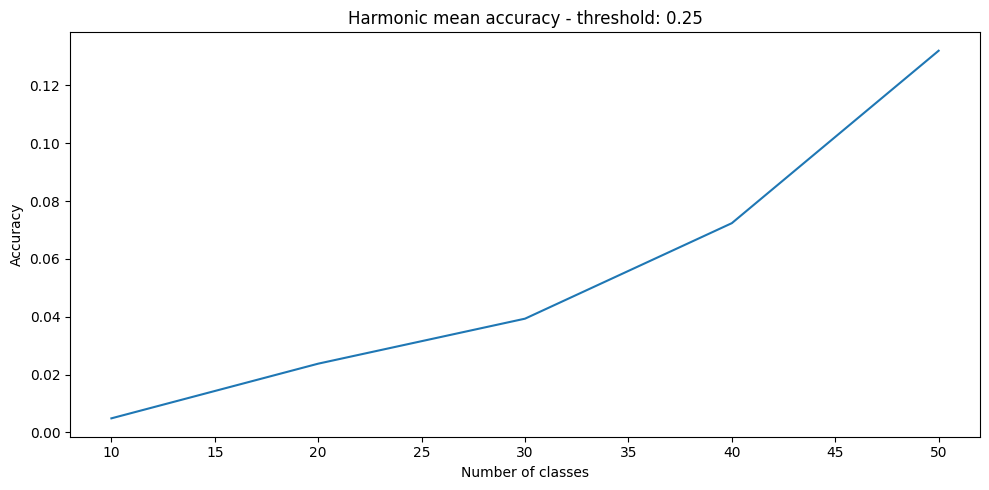

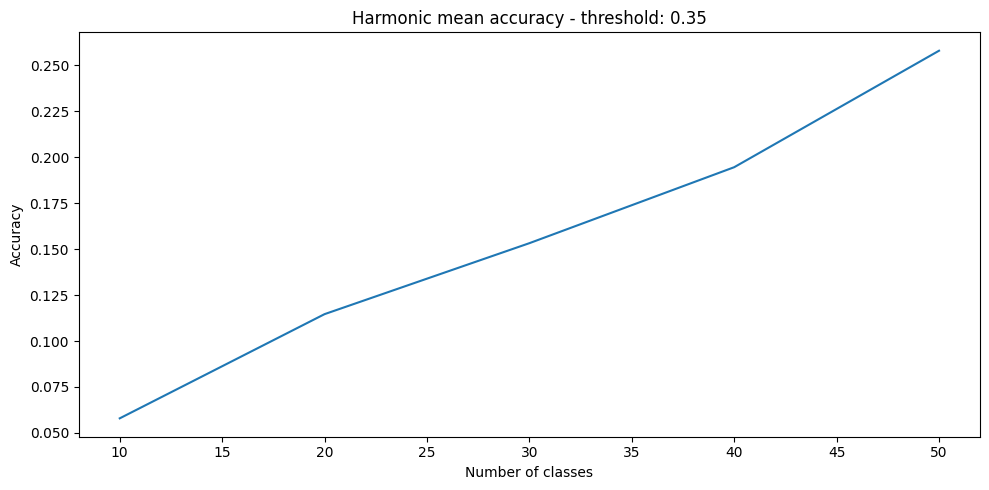

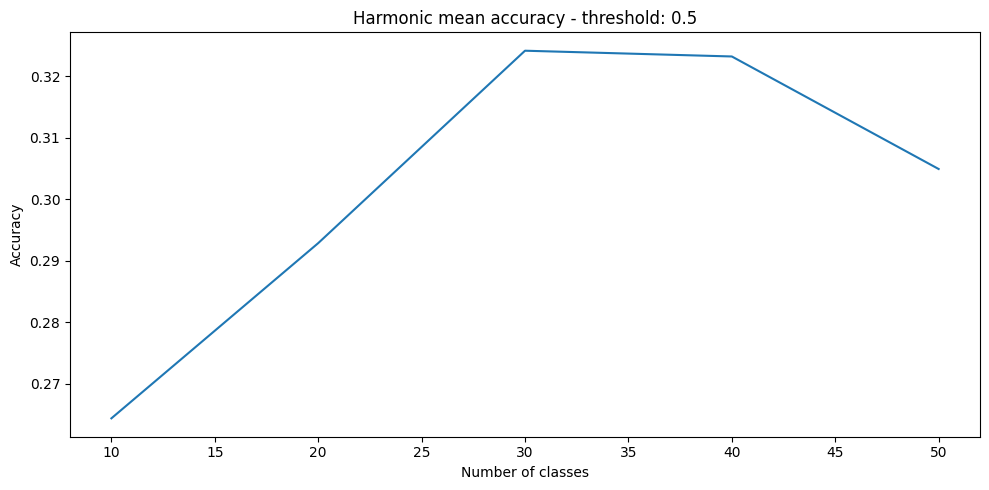

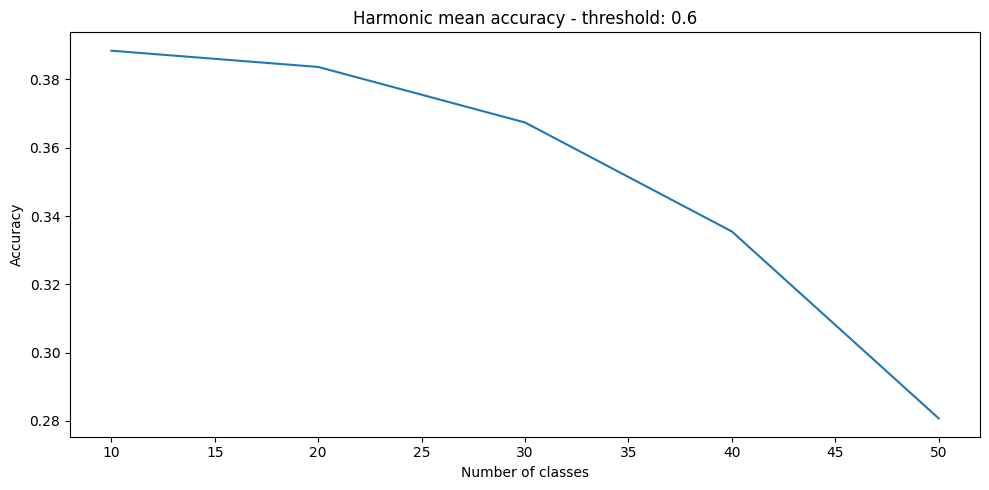

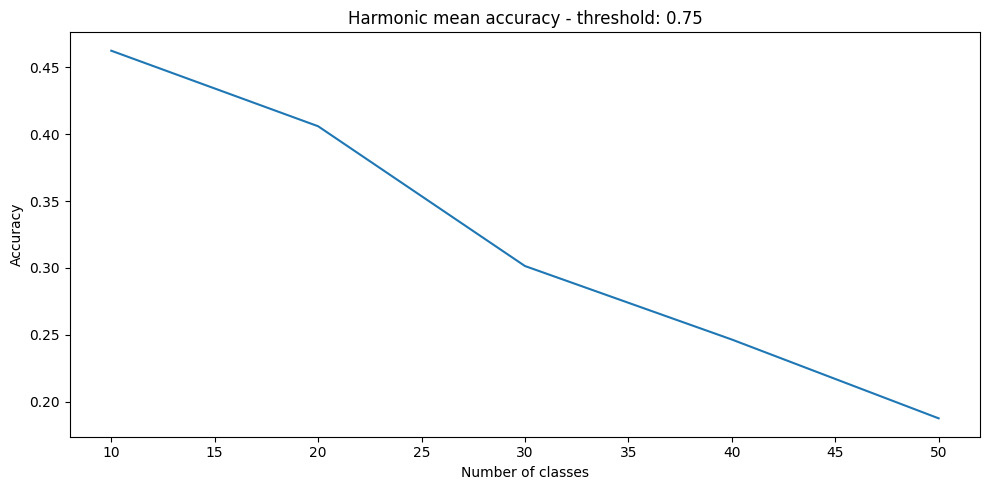

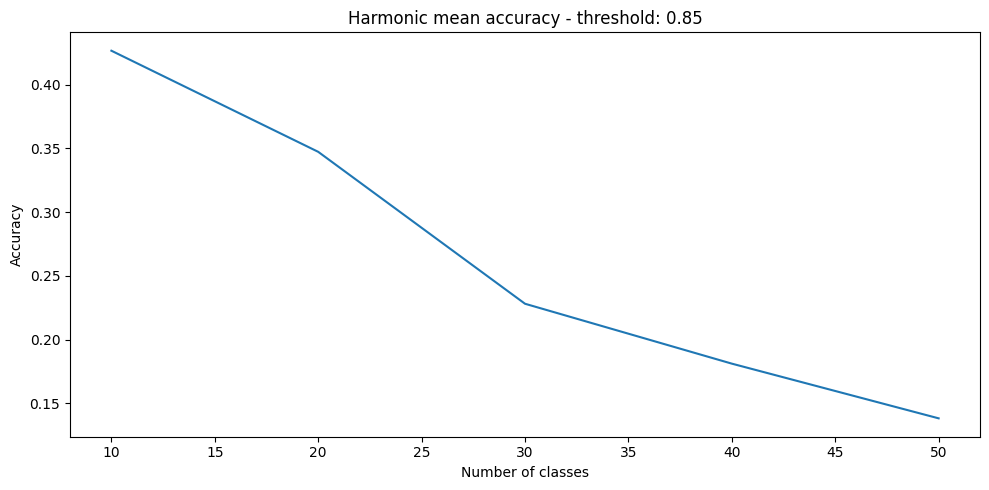

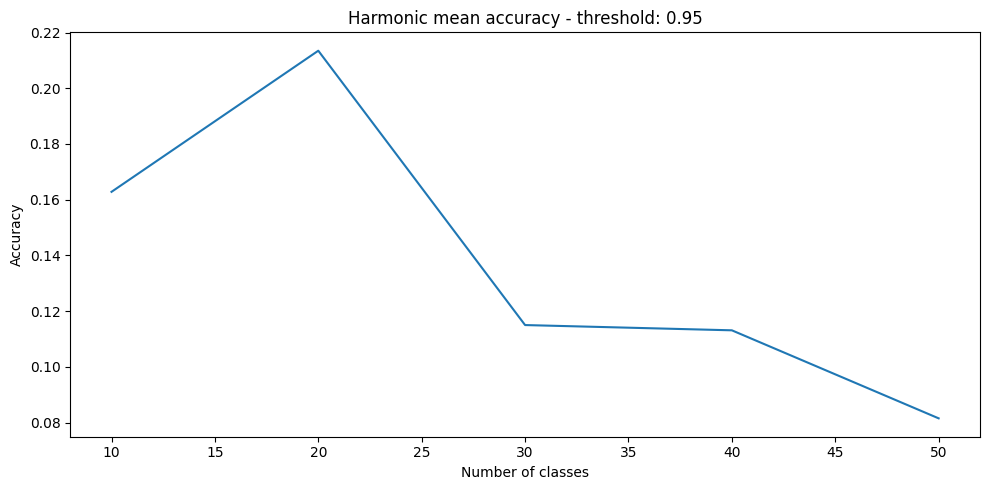

In [24]:
def plot_test(stats, save_directory = None, title = ""):
  mean = np.array(stats[0])
  std = np.array(stats[1])
  fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
  x = np.arange(10, 51, 10)
  ax.errorbar(x, mean, std)
  ax.set_title(f"Harmonic mean accuracy - threshold: {title}")
  ax.set_xlabel("Number of classes")
  ax.set_ylabel("Accuracy")
  plt.tight_layout()
  if save_directory != None:
    fig.savefig(save_directory)
  plt.show()


for i in range(len(REJECTION_THRESHOLD)):
  plot_test(stats = [accuracies_stats[0][i],accuracies_stats[1][i]], title = REJECTION_THRESHOLD[i])

#### Confusion Matrix

In [ ]:
len(true_labels[0])/128

In [ ]:
for i in range(len(REJECTION_THRESHOLD)):
  targets = np.array(true_labels[0])
  preds = np.array(predictions[0][i])
  title = f"Confusion matrix - Threshold: {REJECTION_THRESHOLD[i]}"
  plot_confusion_matrix(targets, preds, RANDOM_SEED[run], title)